In [2]:
import sys
sys.path.insert(0, '../../py3')

In [3]:
from auxilary3 import Helper as hp
import pandas as pd
import numpy as np
%matplotlib inline


In [4]:
# Global variables
host='REPLICA'

In [5]:
db_con = hp.DbExplorer(host)


In [6]:
# Get bars that deliverd successfuly by DM
bar_ids_query = """SELECT * FROM weissserver.bars_metadata
where weissserver.bars_metadata.key = 'QC_approved' and date(weissserver.bars_metadata.value) > '2018-05-01'
and date(weissserver.bars_metadata.value) < '2018-10-01' """
bar_ids = db_con.dbreader(bar_ids_query)
bar_ids = pd.DataFrame(bar_ids)['bar_id'].unique()
len(bar_ids)


../../py3/auxilary3/Helper.py:659: Warning: (1292, "Incorrect datetime value: ''")
  self.cur.execute(q)


1491

In [25]:
# We can query by time or QC approved bars condition
bar_ids_str = ','.join(str(x) for x in bar_ids)
specific_bars_condition = "and bp.bar_id in (" + bar_ids_str + ")"
time_condition = "and date(bp.inserted_at) between '2018-09-01'and '2018-10-01'"

query_pred = """SELECT s.brand_id as brand_prediction, 
                       pb.brand_id as brand_actual, 
                       s.brand_id_prob,
                       s.serving_type_id as serving_type_prediction, 
                       pp.serving_type_id as serving_type_actual, 
                       s.serving_type_id_prob,
                       pb.volume as volume_prediction,
                       s.volume as volume_actual,
                       s.volume_prob as volume_id_prob
                FROM pos_bars_products bp
                JOIN pos_products pp on pp.id = bp.product_id 
                JOIN pos_products_brands pb on pb.product_id = pp.id
                JOIN pos_beer_suggestions s on s.bar_product_id = bp.id
                WHERE bp.category_id = 1
                and pp.id != 0 """ + time_condition

In [26]:
pred_list = db_con.dbreader(query_pred)
len(pred_list)


13215

In [27]:
pred_df = pd.DataFrame(pred_list)
print(pred_df.shape)
pred_df.head()


(13215, 9)


brand_actual  brand_id_prob  brand_prediction  serving_type_actual  \
0        2831.0       0.991243            2831.0                  2.0   
1         128.0       0.999599             128.0                  1.0   
2         128.0       0.999983             128.0                  1.0   
3         128.0       0.999599             128.0                  1.0   
4         828.0       0.558660             828.0                  2.0   

   serving_type_id_prob  serving_type_prediction  volume_actual  \
0              1.000000                      2.0           0.50   
1              0.999419                      1.0           0.33   
2              0.999992                      1.0           0.33   
3              0.999419                      1.0           0.33   
4              0.999999                      2.0           0.30   

   volume_id_prob  volume_prediction  
0        0.998103              0.500  
1        0.999078              0.355  
2        0.999949              0.355  
3        0.999078              0.355  
4        0.930049              0.300

In [28]:
pred_df.serving_type_actual.value_counts()


2.0    7021
1.0    5284
3.0     906
5.0       4
Name: serving_type_actual, dtype: int64

In [29]:
pred_df.brand_actual.value_counts().head(20)


44.0      405
128.0     333
71.0      330
26.0      291
2020.0    224
15.0      214
3.0       198
2039.0    182
2048.0    158
2021.0    147
1301.0    131
280.0     117
1299.0    112
255.0     103
2047.0     99
2095.0     93
3718.0     92
2482.0     92
111.0      92
217.0      91
Name: brand_actual, dtype: int64

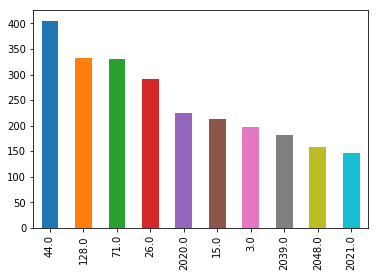

In [30]:
pred_df.brand_actual.value_counts().head(10).plot.bar()


In [31]:
col_options = ['serving_type_', 'brand_', 'volume_']
calc_column_name = col_options[1]
calc_column_name


'brand_'

In [32]:
# print null value count
print('prediction null values = ', sum(pred_df[calc_column_name + 'prediction'].isnull()))
print('actual null values = ', sum(pred_df[calc_column_name + 'actual'].isnull()))

prediction null values =  0
actual null values =  0


In [33]:
if (calc_column_name == 'brand_'):
    pred_df = pred_df[pred_df[calc_column_name + 'actual'].notnull()]

In [34]:
pred_df.loc[pred_df[calc_column_name + 'actual'].isnull(), calc_column_name + 'actual'] = -1
pred_df.loc[pred_df[calc_column_name + 'prediction'].isnull(), calc_column_name + 'prediction'] = -1


In [35]:
report_df =  pred_df[(pred_df[calc_column_name + 'id_prob'] > 0.85)]


In [36]:
report_df.shape[0], pred_df.shape[0], report_df.shape[0]/pred_df.shape[0]


(9324, 13215, 0.7055618615209989)

In [37]:
report_df[calc_column_name + 'actual'].value_counts(dropna=False).head()


44.0     388
128.0    328
71.0     288
26.0     263
15.0     193
Name: brand_actual, dtype: int64

In [38]:
report_df[calc_column_name + 'prediction'].nunique()

907

In [39]:
report_df[calc_column_name + 'actual'] = report_df[calc_column_name + 'actual'].astype(str)
report_df[calc_column_name +'prediction'] = report_df[calc_column_name +'prediction'].astype(str)

/Users/israelsofer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/israelsofer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
from sklearn.metrics import classification_report
target_ids = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
class_report = classification_report(report_df[calc_column_name + 'actual'], 
                            report_df[calc_column_name +'prediction'], digits = 5)
                            #target_names=target_name_list))
print(class_report)


             precision    recall  f1-score   support

        1.0    0.00000   0.00000   0.00000         2
       10.0    1.00000   0.83333   0.90909         6
     1004.0    0.00000   0.00000   0.00000         1
     1006.0    0.50000   1.00000   0.66667         2
    10072.0    1.00000   1.00000   1.00000         1
    10127.0    1.00000   1.00000   1.00000         1
    10182.0    0.00000   0.00000   0.00000         0
      102.0    1.00000   1.00000   1.00000         4
    10201.0    0.00000   0.00000   0.00000         0
     1028.0    1.00000   1.00000   1.00000         3
      103.0    0.00000   0.00000   0.00000         5
     1032.0    1.00000   1.00000   1.00000         3
    10344.0    0.00000   0.00000   0.00000         8
     1036.0    0.33333   1.00000   0.50000         1
     1038.0    0.00000   0.00000   0.00000         0
      104.0    0.80769   1.00000   0.89362        21
     1042.0    1.00000   1.00000   1.00000         2
    10431.0    1.00000   1.00000   1.00000   

/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(report_df[calc_column_name + 'actual'], report_df[calc_column_name + 'prediction'])


0.8896396396396397

In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(report_df[calc_column_name + 'actual'], 
               report_df[calc_column_name + 'prediction'], 
               normalize=False), report_df.shape[0])


23137 30168


In [111]:
#pred_df = pred_df[pred_df.pos_auto_matching_status == 0]


In [167]:
actual_list = db_con.dbreader(query_actual)


In [168]:
actual_df = pd.DataFrame(actual_list)
print(actual_df.shape)
actual_df.head()


(637411, 24)


bar_id barcode  category_id                              code  cost  \
0  12981.0                  3.0  060bbdaffd04e6679922ba5ff61ff021   NaN   
1  12981.0                  2.0  a40642bc75669330776350677643280c   NaN   
2  12982.0                  2.0  4b7e6c6c0017c144687bb32faafd5f6c   NaN   
3  12982.0                  2.0  58076b15ace06e256bc44c77803a7c68   NaN   
4  12982.0                  1.0  bcb8485853e5a4a06731929c6a5c13d1   NaN   

  do_not_learn         id         inserted_at is_guessed machine_translation  \
0      b'\x00'  4045585.0 2018-08-02 00:00:06    b'\x00'                None   
1      b'\x00'  4045586.0 2018-08-02 00:00:06    b'\x00'                None   
2      b'\x00'  4045587.0 2018-08-02 00:00:09    b'\x00'                None   
3      b'\x00'  4045588.0 2018-08-02 00:00:09    b'\x00'                None   
4      b'\x00'  4045589.0 2018-08-02 00:00:09    b'\x00'                None   

       ...       pos_category_name  pos_code  pos_product_volume price  \
0      ...                Shooters     26451                 NaN   6.5   
1      ...                   Wings     34982                 NaN  10.5   
2      ...              Food Preps     39273                 NaN   0.0   
3      ...              Food Preps     40557                 NaN   0.0   
4      ...             Other Draft     36300                 NaN  13.0   

  product_id source  store_number                      title  \
0        0.0    1.0           NaN               Starry Night   
1        0.0    1.0           NaN          10 Pc Naked Wings   
2        0.0    1.0           NaN  5 Boneless Caribbean Jerk   
3        0.0    1.0           NaN           15 Smoked 3 Mile   
4    51063.0    2.0           NaN  Yee Haw - Dunkel, Pitcher   

                  title_orig  units_in_pack  
0               Starry Night            NaN  
1          10 Pc Naked Wings            NaN  
2  5 Boneless Caribbean Jerk            NaN  
3           15 Smoked 3 Mile            NaN  
4  Yee Haw - Dunkel, Pitcher            NaN  

[5 rows x 24 columns]

In [169]:
actual_df.category_id.value_counts(dropna=False)

 2.0    261866
 3.0     90897
 5.0     72632
 6.0     68227
 1.0     60400
 4.0     47274
NaN      36115
Name: category_id, dtype: int64

In [214]:
# show dif matching id count
print(actual_df.shape)
a = actual_df[actual_df.category_id.notnull()]
b = pred_df
print(a.shape, b.shape)

x = b[~b.bar_product_id.isin(a.id.unique())].bar_product_id.unique()
y = actual_df[actual_df.id.isin(x)].id.unique()
print(len(x),len(y))

len(set(x)-set(y))
#a.merge(b, left_on='id', right_on='bar_product_id', how='outer').shape

(637411, 24)
(601296, 24) (690596, 9)
112182 35791


76391

In [247]:
merge_category_df = actual_df.merge(pred_df, left_on='id', right_on='bar_product_id')
merge_category_df.rename(columns={'category_id_x' : 'category_id_actual', 'category_id_y' : 'category_id_pred'}, inplace=True)
merge_category_df.shape

(614205, 33)

In [264]:
merge_category_df.loc[merge_category_df.category_id_actual.isnull(),'category_id_actual'] = -1

In [265]:
merge_category_df['category_id_actual'].value_counts(dropna=False)

 2.0    253170
 3.0     87135
 5.0     69371
 6.0     65983
 1.0     56781
 4.0     45974
-1.0     35791
Name: category_id_actual, dtype: int64

In [266]:
merge_category_df['category_id_pred'].value_counts(dropna=False)


2.0    265690
3.0     88166
5.0     79671
6.0     68587
1.0     62254
4.0     49819
0.0        18
Name: category_id_pred, dtype: int64

In [267]:
query_category_lookup = "SELECT * FROM weissserver.pos_categories order by id"
target_list = db_con.dbreader(query_category_lookup)
target_name_list = pd.DataFrame(target_list)
print(target_name_list)

    id                    title
0  1.0                     Beer
1  2.0                     Food
2  3.0                  Spirits
3  4.0  Non Alcoholic Beverages
4  5.0                   Others
5  6.0                     Wine


In [296]:
report_df =  merge_category_df[(merge_category_df.category_id_prob > 0.7)]

In [297]:
report_df.shape[0], merge_category_df.shape[0], report_df.shape[0]/merge_category_df.shape[0]

(576364, 614205, 0.9383902768619597)

In [298]:
from sklearn.metrics import classification_report
target_ids = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
print(classification_report(report_df['category_id_actual'], 
                            report_df['category_id_pred']))
                            #target_names=target_name_list))
    

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00     16109
        1.0       0.95      0.96      0.95     55183
        2.0       0.97      0.99      0.98    247110
        3.0       0.98      0.96      0.97     84940
        4.0       0.91      0.98      0.95     44291
        5.0       0.86      0.94      0.90     64502
        6.0       0.97      0.99      0.98     64229

avg / total       0.92      0.95      0.94    576364



/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [281]:
from sklearn.metrics import accuracy_score
accuracy_score(report_df['category_id_actual'], report_df['category_id_pred'])



0.9696012577072807

In [282]:
accuracy_score(report_df['category_id_actual'], report_df['category_id_pred'], normalize=False)


545200

## Report auto matching rate

In [283]:
start = 0.8
threshold_list = []
matching_size_list = []
for i in range(1,20):
    threshold = 0.8 + 0.01 * i
    matching_size = sum(report_df.category_id_prob > threshold)/report_df.shape[0]
    threshold_list.append(threshold)
    matching_size_list.append(matching_size)
print(matching_size_list)
print(threshold_list)      

[0.9933326575290818, 0.9907841641279547, 0.987654123384072, 0.9847125964577187, 0.9818226440663498, 0.97844540124099, 0.9745097306920057, 0.9705207071757962, 0.9654646243150813, 0.9609047240495614, 0.9563021414102612, 0.9510415388418494, 0.9456493322876152, 0.9388290446439845, 0.9308421054503613, 0.9235131861858498, 0.9129706398621359, 0.8985404406599407, 0.8754386058513978]
[0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.8500000000000001, 0.8600000000000001, 0.8700000000000001, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.9600000000000001, 0.9700000000000001, 0.98, 0.99]


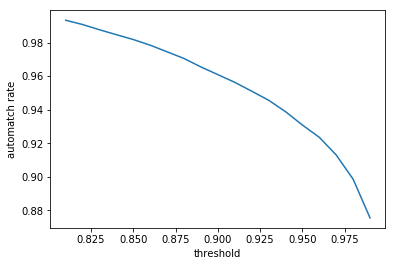

In [284]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(threshold_list, matching_size_list)
plt.xlabel('threshold')
plt.ylabel('automatch rate')
plt.show()